# Dynamic Time Warping with constraints
DTW code and examples taken and revised from:
      https://pypi.python.org/pypi/dtw


In [ ]:
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 16,4

Populating the interactive namespace from numpy and matplotlib


## DTW with Sakoe-Chiba band -- basic implementation

In [ ]:
def dtw_band(x, y, dist, band=inf):
    """
    Computes Dynamic Time Warping (DTW) of two sequences with Sakoe-Chiba band.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int band: size of Sakow-Chiba band (default=inf)

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    # Effect of bands: cells farther than "band" from diagonal have "inf" cost
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j]) if abs(i-j)<band else inf
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [ ]:
def distance(x,y):
    return abs(x-y)

#### Read and plot a 100-points sample of the sound waves dataset
Remark: now we use normalized values. The simple plot looks the same as before, but DTW changes...

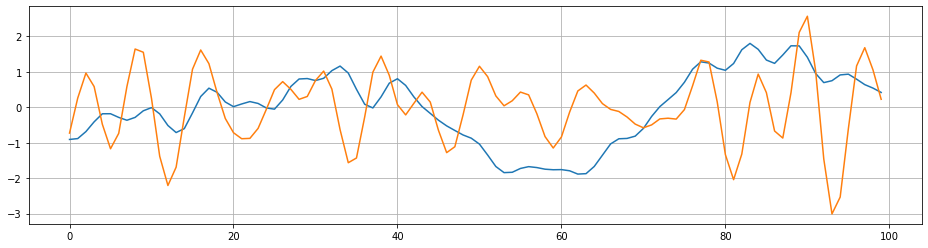

In [ ]:
import librosa
y, sr = librosa.load('sounds_0.wav')
y2, sr2 = librosa.load('sounds_8.wav')

rcParams['figure.figsize'] = 16,4
offset = 5200
win = 100
ys = y[offset:(offset+win)]
ys2 = y2[offset:(offset+win)]
# Normalize
ys = (ys - ys.mean()) / ys.std()
ys2 = (ys2 - ys2.mean()) / ys2.std()
pyplot.grid(True)
plot(ys)
plot(ys2)
show()

#### Our old function to plot optimal path computed by DTW

In [ ]:
def matrix_and_best_path(mymatrix,path):
    import seaborn as sns
    sns.reset_orig()
    sns.set_context('notebook', font_scale=2.5)
    imshow(mymatrix.T, origin='lower', cmap=cm.gray, interpolation='nearest')
    title('Optimal path')
    plot(path[0], path[0], 'c-')
    plot(path[0], path[1], 'y')
    plot(path[0], path[1], 'ro')
    xlim(-0.5,mymatrix.shape[0]-0.5)
    ylim(-0.5,mymatrix.shape[1]-0.5)

### Basic usage of DTW_band: no band => standard DTW

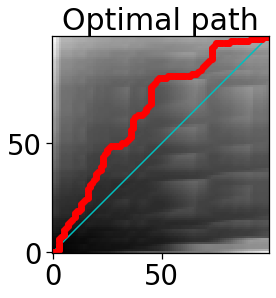

In [ ]:
d, aa, cc, ll = dtw_band(ys,ys2,distance)
matrix_and_best_path(cc,ll)

### The DTW alignment plot

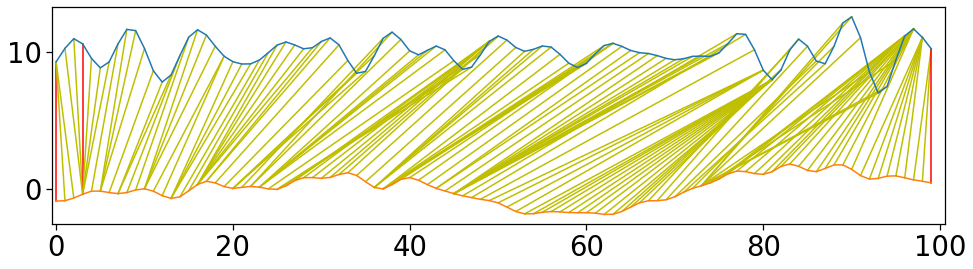

In [ ]:
rcParams['figure.figsize'] = 16,4

yshift = 10  # shifts y a bit to make the plot more readable
for (i,j) in zip(ll[0],ll[1]):
    col = 'r-' if i == j else 'y-'
    plot([ i, j ] , [ ys[i], ys2[j]+yshift ], col)
xlim(-0.5,max(len(ys),len(ys2))+0.5)
plot(ys2+yshift)
plot(ys)
show()

### Using a large band

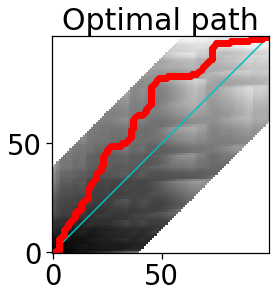

In [ ]:
d, aa, cc, ll = dtw_band(ys,ys2,distance,band=40)
matrix_and_best_path(cc,ll)

### Using a narrower and narrower band

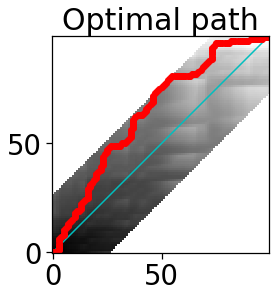

In [ ]:
d, aa, cc, ll = dtw_band(ys,ys2,distance,band=27)
matrix_and_best_path(cc,ll)

### Same as above, now with alignment plots

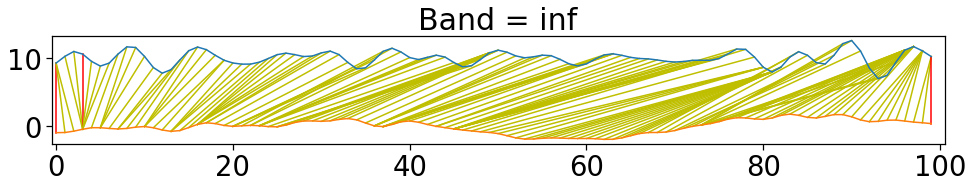

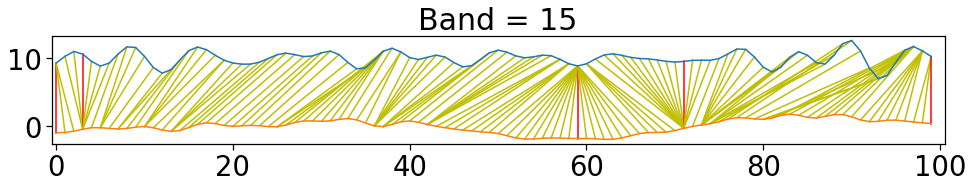

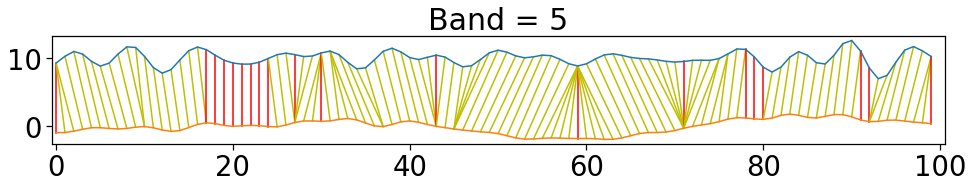

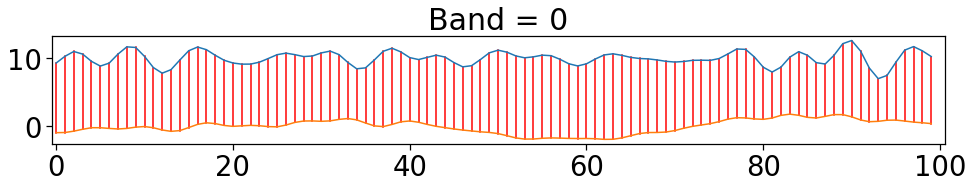

In [ ]:
rcParams['figure.figsize'] = 16,2

for b in [inf, 15, 5, 0]:
    d, aa, cc, ll = dtw_band(ys,ys2,distance,band=b)
    pyplot.title("Band = %s" % b)
    yshift = 10  # shifts y a bit to make the plot more readable
    for (i,j) in zip(ll[0],ll[1]):
        col = 'r-' if i == j else 'y-'
        plot([ i, j ] , [ ys[i], ys2[j]+yshift ], col)
    xlim(-0.5,max(len(ys),len(ys2))+0.5)
    plot(ys2+yshift)
    plot(ys)
    pyplot.show()

## Remind: narrower band => less paths admissible by DTW => worse (higher) DTW value

> Blocco con rientro


We can see what happens to the DTW when we apply bands of different sizes to the same pair of time series.

DTW-band(b) for increasing values of b (red line is b=inf):


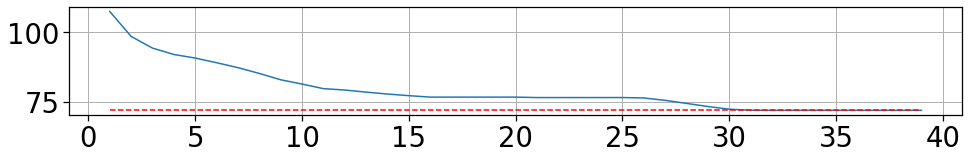

In [ ]:
bvals = range(1,40)
d_list = [ dtw_band(ys,ys2,distance,band=b)[0] for b in bvals ]
best_d = dtw_band(ys,ys2,distance,band=inf)[0]
pyplot.grid(True)
plot(bvals, d_list)
plot([bvals[0],bvals[-1]],[best_d, best_d], 'r--')
print("DTW-band(b) for increasing values of b (red line is b=inf):")

## DTW with Itakura parallelogram -- basic implementation

In [ ]:
def dtw_parallel(x, y, dist, coeff=inf):
    """
    Computes Dynamic Time Warping (DTW) of two sequences with Itakura Parallelogram constraints

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param float coeff: angular coefficient of parallelogram (default=inf)

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j]) if abs(j-i) < (min(i,j,r-i,c-j)+1)*coeff else inf
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

#### Play with various coefficients
Start from 1.0 and try increasing or decreasing it.

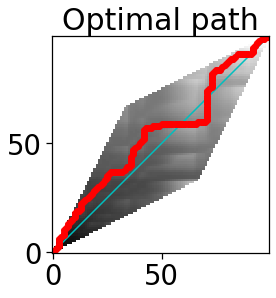

In [ ]:
d, aa, cc, ll = dtw_parallel(ys,ys2,distance, coeff=1.0)
matrix_and_best_path(cc,ll)

### As for Sakoe-Chiba, narrower parallelogram (small coeff.) => worse DTW (higher) value

DTW-parallel(c) for increasing values of c (red line is c=inf):


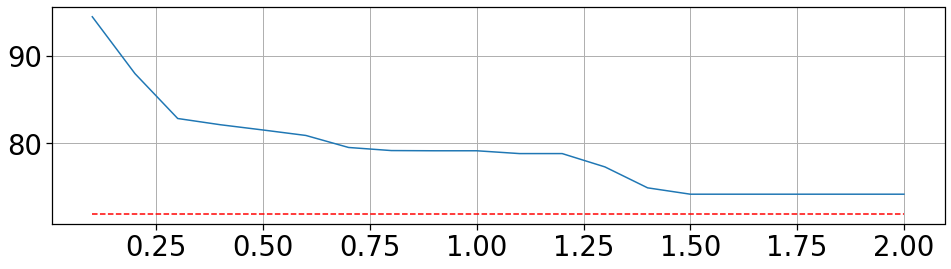

In [ ]:
rcParams['figure.figsize'] = 16,4
cvals = linspace(0.1,2.0,20)
d_list = [ dtw_parallel(ys,ys2,distance,coeff=c)[0] for c in cvals ]
best_d = dtw_parallel(ys,ys2,distance)[0]
pyplot.grid(True)
plot([cvals[0],cvals[-1]],[best_d, best_d], 'r--')
plot(cvals,d_list)
print("DTW-parallel(c) for increasing values of c (red line is c=inf):")

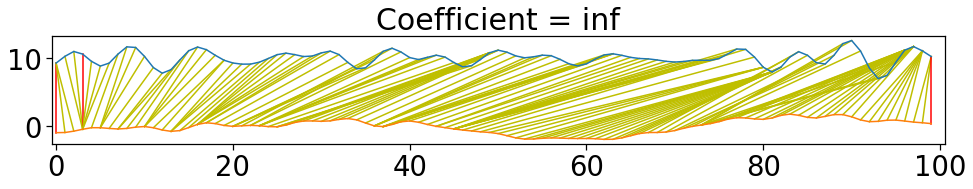

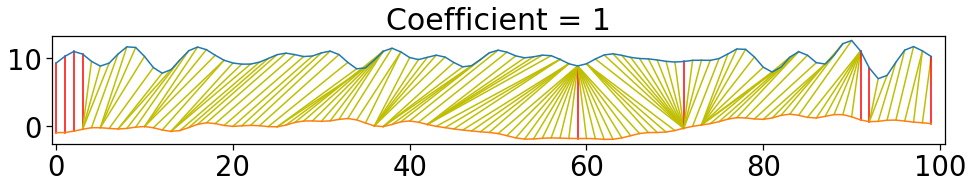

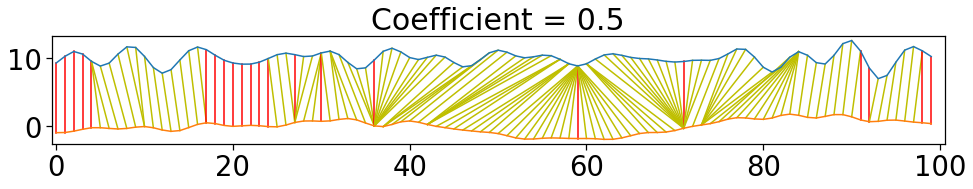

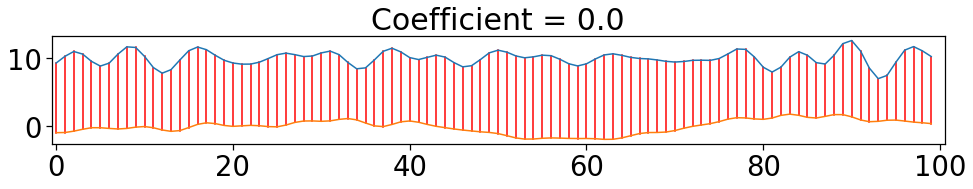

In [ ]:
rcParams['figure.figsize'] = 16,2

for c in [inf, 1, 0.5, 0.0]:
    d, aa, cc, ll = dtw_parallel(ys,ys2,distance,coeff=c)
    pyplot.title("Coefficient = %s" % c)
    yshift = 10  # shifts y a bit to make the plot more readable
    for (i,j) in zip(ll[0],ll[1]):
        col = 'r-' if i == j else 'y-'
        plot([ i, j ] , [ ys[i], ys2[j]+yshift ], col)
    xlim(-0.5,max(len(ys),len(ys2))+0.5)
    plot(ys2+yshift)
    plot(ys)
    pyplot.show()